In [1]:
import os
import logging
import llmParser
import pdfplumber
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

Modelo de Ollama cargado correctamente.


In [2]:
# Directrorios requeridos:
homePath = os.path.expanduser('~') # Ruta del directorio de inicio del usuario
dataPath = os.path.join(homePath, 'NLP_p2025', 'CVBestFit') # Ruta del directorio de trabajo
cvsPath = os.path.join(dataPath, 'cvs') # Ruta donde se almacenan los CVs sin procesar
jobDescriptionsPath = os.path.join(dataPath, 'jobDescriptions') # Ruta donde se almacenan los documentos descriptivos
jobDescriptionFile = os.path.join(jobDescriptionsPath, 'Especialista en Instrumentacion y control.pdf') # Directorio del documento descriptivo

In [3]:
def extractText(docPath):
    """ Extrae y concatena el texto de todas las páginas de un archivo PDF."""
    with pdfplumber.open(docPath) as pdf:
        return "\n".join([page.extract_text() or '' for page in pdf.pages])
    
def extractCVsInfo(cvPath):
    """ Extrae la información de los CVs en un directorio dado y la almacena en un diccionario formateado."""

    ######################## Suprimir avisos de pdfplumber sobre cropbox ############################
    logging.getLogger("pdfminer").setLevel(logging.ERROR)
    logging.getLogger("pdfplumber").setLevel(logging.ERROR)

    parser = llmParser.LLMParser() # Cargar modelo de lenguaje para parsear la información de los CVs
    cvDict = {} #Diccionario con la información de los CVs:

    for i, file in enumerate(os.listdir(cvPath)):
        if file.endswith('.pdf'):
            cPath = os.path.join(cvPath, file)
            text = extractText(cPath) # Extraer el texto del documento actual
            cvInfo = parser.extract_CVInfo(text, True) # Extrae la información solicitada en formato JSON
            
        cvDict[i] = cvInfo # Almacenar la información del CV en el diccionario
        print(f"Procesado: {cPath}")

    return cvDict

def extractJobDescriptionInfo(jobDescriptionFile):
    """ Extrae la información de los CVs en un directorio dado y la almacena en un diccionario formateado."""

    ######################## Suprimir avisos de pdfplumber sobre cropbox ############################
    logging.getLogger("pdfminer").setLevel(logging.ERROR)
    logging.getLogger("pdfplumber").setLevel(logging.ERROR)

    parser = llmParser.LLMParser() # Cargar modelo de lenguaje para parsear y castear la información de los CVs
    jobDescriptionText = extractText(jobDescriptionFile) # Extraer el texto del documento actual
    jobDescriptionInfo = parser.extract_jobDescriptionInfo(jobDescriptionText) # Extrae la información solicitada en formato JSON

    return jobDescriptionInfo

def radarSkills(scoresPerSkill, jobInfo, candidatos=None, mode="individual"):
    """
    Visualiza habilidades en gráficos de radar según el modo seleccionado.

    Parámetros:
    - scoresPerSkill: dict con las similitudes normalizadas (0 a 10) por habilidad para cada candidato.
    - jobInfo: objeto con atributos hardSkills y softSkills.
    - candidatos: lista opcional de candidatos a comparar (solo para modo 'compare').
    - modo: 'individual', 'hard', 'soft', 'compare'.
    """

    if mode not in ["individual", "hard", "soft", "compare"]:
        raise ValueError("Modo inválido. Usa: 'individual', 'hard', 'soft', o 'compare'.")

    hardSkills = jobInfo.hardSkills
    softSkills = jobInfo.softSkills

    if mode == "individual":
        for candidato, skills in scoresPerSkill.items():
            fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(polar=True))
            fig.suptitle(f"Habilidades de {candidato}", fontsize=16)

            # Técnicas
            values = [skills.get(skill, 0) for skill in hardSkills]
            values += values[:1]
            angles = np.linspace(0, 2 * np.pi, len(hardSkills), endpoint=False).tolist()
            angles += angles[:1]
            axs[0].plot(angles, values, linewidth=2)
            axs[0].fill(angles, values, alpha=0.25)
            axs[0].set_xticks(angles[:-1])
            axs[0].set_xticklabels(hardSkills, fontsize=9)
            axs[0].set_title("Técnicas", pad=15)

            # Blandas
            values = [skills.get(skill, 0) for skill in softSkills]
            values += values[:1]
            angles = np.linspace(0, 2 * np.pi, len(softSkills), endpoint=False).tolist()
            angles += angles[:1]
            axs[1].plot(angles, values, linewidth=2)
            axs[1].fill(angles, values, alpha=0.25)
            axs[1].set_xticks(angles[:-1])
            axs[1].set_xticklabels(softSkills, fontsize=9)
            axs[1].set_title("Blandas", pad=15)

            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()

    elif mode == "hard":
        for candidato, skills in scoresPerSkill.items():
            values = [skills.get(skill, 0) for skill in hardSkills]
            values += values[:1]
            angles = np.linspace(0, 2 * np.pi, len(hardSkills), endpoint=False).tolist()
            angles += angles[:1]

            fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
            ax.plot(angles, values, linewidth=2)
            ax.fill(angles, values, alpha=0.25)
            ax.set_xticks(angles[:-1])
            ax.set_xticklabels(hardSkills, fontsize=9)
            ax.set_title(f"{candidato} - Habilidades Técnicas", pad=20)
            plt.tight_layout()
            plt.show()

    elif mode == "soft":
        for candidato, skills in scoresPerSkill.items():
            values = [skills.get(skill, 0) for skill in softSkills]
            values += values[:1]
            angles = np.linspace(0, 2 * np.pi, len(softSkills), endpoint=False).tolist()
            angles += angles[:1]

            fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
            ax.plot(angles, values, linewidth=2)
            ax.fill(angles, values, alpha=0.25)
            ax.set_xticks(angles[:-1])
            ax.set_xticklabels(softSkills, fontsize=9)
            ax.set_title(f"{candidato} - Habilidades Blandas", pad=20)
            plt.tight_layout()
            plt.show()

    elif mode == "compare":
        if not candidatos or len(candidatos) < 2:
            raise ValueError("Para 'compare', proporciona una lista de al menos dos candidatos.")

        allSkills = hardSkills + softSkills
        angles = np.linspace(0, 2 * np.pi, len(allSkills), endpoint=False).tolist()
        angles += angles[:1]

        fig, ax = plt.subplots(figsize=(14, 7), subplot_kw=dict(polar=True))
        ax.set_title("Comparación de Habilidades", pad=20)

        for cand in candidatos:
            if cand not in scoresPerSkill:
                continue
            skills = scoresPerSkill[cand]
            values = [skills.get(skill, 0) for skill in allSkills]
            values += values[:1]
            ax.plot(angles, values, linewidth=2, label=cand)
            ax.fill(angles, values, alpha=0.1)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(allSkills, fontsize=9)
        ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
        plt.tight_layout()
        plt.show()

### Funciones para evaluar el perfil general del candidato contra la vacante:

In [4]:
# Se define la función de vectorización del corpus:
def tfIdfWeightedEmbedding(texts, modelW2V):
    """Vectoriza el corpus de textos usando TF-IDF y calcula los embeddings ponderados de cada documento."""
    if isinstance(texts, str):  # Si es solo una frase, la convertimos a lista
        texts = [texts]
    
    # Se vectorizan con TF-IDF los textos (documentos)
    vectorizerTfIdf = TfidfVectorizer()
    tfIdfVectors = vectorizerTfIdf.fit_transform(texts)
    uniqueWords = vectorizerTfIdf.get_feature_names_out()

    # Se mapean los pesos TF-IDF:
    tfIdfWeights = []
    for doc in tfIdfVectors:
        wordWeight = {uniqueWords[i]: doc[0, i] for i in doc.nonzero()[1]}
        tfIdfWeights.append(wordWeight)

    # Se calculan los embeddings ponderados de cada documento:
    embedings = {}

    for i, doc in enumerate(texts):
        weights = [] # Pesos TF-IDF
        vectors = [] # Vectores ponderados de las palabras encontradas
        tokens = doc.split() # Documentos tokenizados

        for word in tokens:
            if word in modelW2V.wv and word in tfIdfWeights[i]:
                vectors.append(modelW2V.wv[word] * tfIdfWeights[i][word]) # Se guarda el vector ponderado
                weights.append(tfIdfWeights[i][word]) # Se guarda el peso TF-IDF de la palabra

        if vectors: # Sí hay palabras con word embeddings y TF-IDF:
            embedings[i] = np.sum(vectors, axis=0) / sum(weights) # Calcular el promedio ponderado de los vectores
        else: # Sí no:
            embedings[i] = np.zeros(modelW2V.vector_size) # Regresar un vector de ceros para ese documento

    return embedings

### Funciones para evaluar las habilidades de los candidatos contra la vacante

In [5]:
# Se definen las funciones para calcular el score heurístico de similitud entre habilidades:
def evaluateSkill(modelST, jobSkills, cvSkills, weight, mandatorySkill=False, threshold=0.3):
    """ Evalúa la similitud entre las habilidades de un CV y las habilidades requeridas para un puesto de trabajo."""	
    score = 0
    totalScore = 0

    skillDict = {} # Diccionario para almacenar las habilidades laborales y sus scores por candidato

    for jobSkill in jobSkills:
        jobSkillVec = modelST.encode(jobSkill) # Extraer el vector de la habilidad usando el modelo SentenceTransformer
        maxSim = 0

        for cvSkill in cvSkills:
            cvSkillVec = modelST.encode(cvSkill) # Extraer el vector de la habilidad usando el modelo SentenceTransformer
            # Calcular la similitud coseno entre los vectores de las habilidades
            cosSim = cosine_similarity([jobSkillVec], [cvSkillVec]).item()

            maxSim = max(cosSim, maxSim) # Guardar la máxima similitud entre las habilidades

            #print(f"Similitud entre '{jobSkill}' y '{cvSkill}': {cosSim:.2f}") # Mostrar la similitud entre las habilidades

        totalScore += weight

        if mandatorySkill: # Si la habilidad es obligatoria:
            score = weight if cosSim >= threshold else -weight # Penalizar si no cumple el umbral

        else: # Si la habilidad no es obligatoria:
            score = weight if cosSim >= threshold else 0 # No penalizar si no cumple el umbral

        skillDict[jobSkill] = maxSim # Guardar el score de la habilidad en el diccionario
        

    return score, totalScore, skillDict # Regresar el score heurístico y el total de puntos posibles


def heuristicSkillScore(jobInfo, cvDict, modelST):
    """Calcula el score de similitud y retorna un diccionario con los scores individuales por habilidad requerida."""

    weights = {
        "hardSkills": 5,
        "softSkills": 3,
        "mandatoryHardSkills": 10,
        "mandatorySoftSkills": 6
    }

    categories = [
        (modelST, jobInfo.hardSkills, cvDict.hardSkills, weights["hardSkills"]),
        (modelST, jobInfo.softSkills, cvDict.softSkills, weights["softSkills"]),
    ]

    score = 0
    totaPossibleScore = 0
    mergedSkillDict = {}  # Para juntar todos los resultados

    for cat in categories:
        # Soportar tanto con como sin `mandatorySkill`
        if len(cat) == 4:
            modelST, jobSkills, cvSkills, weight = cat
            mandatory = False
        else:
            modelST, jobSkills, cvSkills, weight, mandatory = cat

        if cvSkills:
            subScore, subTotal, skillDict = evaluateSkill(modelST, jobSkills, cvSkills, weight, mandatory)
            score += subScore
            totaPossibleScore += subTotal
            mergedSkillDict.update(skillDict)  # Combinar diccionarios
        else:
            continue

    heuristicScore = max(score, 0) / totaPossibleScore if totaPossibleScore else 0

    return heuristicScore, mergedSkillDict

In [6]:
# Se extrae la información de los CVs y el puesto de trabajo:
cvsInfo = extractCVsInfo(cvsPath) # Extraer la información de los CVs
jobInfo = extractJobDescriptionInfo(jobDescriptionFile) # Extraer la información de la vacante

CV Information Response:
 {
  "name": "MANUEL",
  "email": "mljch21@gmail.com",
  "phone": "",
  "location": "Panamá",
  "profile": "Ingeniero Electromecánico con 3 años de experiencia en el diseño, implementación y optimización de sistemas mecánicos y eléctricos en diversos sectores industriales. Poseo un sólido conocimiento en el manejo de herramientas de ingeniería, análisis estructural, control de procesos y mantenimiento de maquinaria.",
  "experience": ["METALFER (AES) PLANTA HIDROELECTRICA BAYANO", "EMPRESAS MELO", "ACISA PANAMÁ"],
  "education": ["UNIVERSIDAD TECNOLOGICA DE Panamá", "COLEGIO JOSÉ DANIEL CRESPO"],
  "hardSkills": ["Excel Intermedio", "Autocad", "360 Office", "SAP", "SCADA ABB"],
  "softSkills": ["Trabajo en equipo", "Lectura de planos eléctricos y de control"]
}
Procesado: C:\Users\estiv\NLP_p2025\CVBestFit\cvs\CurriculumProfesionalSinFotoSencilloBlancoyNegro.pdf
CV Information Response:
 {
  "name": "Juan Pablo Ocampo",
  "email": "juanp.ocampo06@gmail.com",
  

In [8]:
# Cargar modelos necesarios para el procesamiento de texto:
modelST = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2') # Cargar el modelo de SentenceTransformer
modelW2V = Word2Vec.load(r"./modelW2V/modelW2V.model")# Se carga el modelo word2vec entrenado

# Se almacenan los textos de los CVs:
rawTexts = [] # Texto de los CVs de la vacante actual

for i in range(len(cvsInfo)):
    cvText = cvsInfo[i].profile # Extraer el peril del CV del candidato
    rawTexts.append(cvText) # Almacenar el texto del CV

# Extraer la descripción y responsabilidades del puesto trabajo
jobDescription = jobInfo.description + " ".join(jobInfo.responsibilities) # Extraer la descripción y responsabilidades del puesto de trabajo

# Se almacenan el texto de la vacante:
rawTexts.append(jobDescription)

# Extraer TF-IDF embeddings ponderados de los CVs y descripciones de la vacante actual:
lowerRawTexts = [text.lower() for text in rawTexts] # Convertir a minúsculas
embeddings = tfIdfWeightedEmbedding(lowerRawTexts, modelW2V) # Extraer TF-IDF embeddings

In [9]:
jobDescriptionVec = embeddings[len(embeddings)-1]  # El último vector ponderado corresponde a la descripción de la vacante

scores = {} # Se almacenan los scores (similitud coseno) de cada CV
heuristicScores = {} # Se almacenan los scores heurísticos de cada CV
scoresPerSkill = {}

for i, file in enumerate(os.listdir(cvsPath)):
    if file.endswith('.pdf'):
        cosSim = cosine_similarity([jobDescriptionVec], [embeddings[i]]).item() # Calcular similitud del CV contra la descripción
        nameCV = cvsInfo[i].name
        nameCV = nameCV.title() # Convertir el nombre del CV a formato título

        scores[nameCV] = cosSim # Se guarda el score como valor y el nombre del CV como clave
        heuristicScores[nameCV], skillDict = heuristicSkillScore(jobInfo, cvsInfo[i], modelST) # Calcular el score heurístico

        scoresPerSkill[nameCV] = skillDict # Almacenar el score heurístico por habilidad

    ######################## Suprimir avisos de pdfplumber sobre cropbox ############################
    logging.getLogger("pdfminer").setLevel(logging.ERROR)

# Se ordenan los scores de manera descendente:
scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))
heuristicScores = dict(sorted(heuristicScores.items(), key=lambda item: item[1], reverse=True))

combinedScores = {} # Se almacenan los scores combinados de cada CV

for candidate in scores:
    combinedScore = (0.8 * scores[candidate] + 0.2 * heuristicScores[candidate]) # Calcular el score combinado
    percentageScore = round(combinedScore * 100, 2) # Convertir a porcentaje
    combinedScores[candidate] = percentageScore # Almacenar el score combinado

combinedScores = dict(sorted(combinedScores.items(), key=lambda item: item[1], reverse=True)) # Ordenar los scores combinados de manera descendente

In [10]:
# Crear un DataFrame con la información de la descripción del puesto de trabajo:
jobData = {key: value for key, value in jobInfo.model_dump().items()}  # Utiliza dict() para convertir el modelo a diccionario
dfJobDesc = pd.DataFrame([jobData])  # Convertir a DataFrame
dfJobDesc.columns = ["Titulo", "Descripción", "Responsabilidades", "Habilidades Técnicas", "Habilidades Blandas", "Ubicación"]  # Renombrar columnas

display(dfJobDesc) # Mostrar el DataFrame

,Titulo,Descripción,Responsabilidades,Habilidades Técnicas,Habilidades Blandas,Ubicación
0,Mantenimiento y Control de Planta,Responsable del mantenimiento y creación de ba...,[Realizar trabajo de mantenimiento y crear bac...,"[SAP Modulo de mantenimiento, ELECTRONICA, OFF...","[Calibracion de sensores, electroneumatica, Co...",Panama


In [11]:
# Crear un DataFrame con la información de los CVs:
cvData = {key: value.model_dump() for key, value in cvsInfo.items()} # Convertir a diccionario
dfCVs = pd.DataFrame(cvData).T # Convertir a DataFrame
dfCVs.columns = ["Nombre", "Correo", "Teléfono", "Perfil", "Ubicación", "Experiencia", "Educación", "Habilidades Técnicas", "Habilidades Blandas"] # Renombrar columnas
dfCVs.set_index("Nombre", inplace=True) # Establecer la columna "name" como índice
dfCVs = dfCVs[~dfCVs.index.duplicated(keep='first')] # Eliminar duplicados

In [12]:
# Crear un DataFrame con los scores:
scoresDF = pd.DataFrame(list(scores.items()), columns=['Candidato', 'Puntuación']) # Crear un DataFrame
display(scoresDF) # Mostrar el DataFrame

,Candidato,Puntuación
0,Abdiel Jimenez,0.988559
1,Manuel,0.975582
2,Harllyn Velazco,0.934378
3,Juan Pablo Ocampo,0.925824
4,Miguel Gutiérrez,0.888833
5,Carol B. Fruto S.,0.861050
6,Juan Carlo,0.806418
7,Hipolito Rodriguez,0.589651
8,Kirvin Adriel Caballero González,0.393711
9,Emanuel Valdés,0.355757


In [13]:
# Crear un DataFrame con los scores:
heuristicScoresDF = pd.DataFrame(list(heuristicScores.items()), columns=['Candidato', 'Puntuación Heurística']) # Crear un DataFrame
display(heuristicScoresDF) # Mostrar el DataFrame

,Candidato,Puntuación Heurística
0,Kirvin Adriel Caballero González,0.333333
1,Carol B. Fruto S.,0.208333
2,Emanuel Valdés,0.208333
3,Juan Carlo,0.208333
4,Miguel Gutiérrez,0.208333
5,Manuel,0.125000
6,Hipolito Rodriguez,0.125000
7,Juan Pablo Ocampo,0.000000
8,Abdiel Jimenez,0.000000
9,Estiven Angel Echeverria,0.000000


In [14]:
combinedScoresDF = pd.DataFrame(list(combinedScores.items()), columns=['Candidato', 'Porcentaje de afinidad']) # Crear un DataFrame
display(combinedScoresDF) # Mostrar el DataFrame

,Candidato,Porcentaje de afinidad
0,Manuel,80.55
1,Abdiel Jimenez,79.08
2,Miguel Gutiérrez,75.27
3,Harllyn Velazco,74.75
4,Juan Pablo Ocampo,74.07
5,Carol B. Fruto S.,73.05
6,Juan Carlo,68.68
7,Hipolito Rodriguez,49.67
8,Kirvin Adriel Caballero González,38.16
9,Emanuel Valdés,32.63


In [15]:
# Agregar el score combinado al DataFrame de CVs:
dfCVs['Porcentaje de afinidad'] = pd.Series(combinedScores) # Agregar la columna de scores al DataFrame
dfCVs = dfCVs.sort_values(by='Porcentaje de afinidad', ascending=False) # Ordenar el DataFrame por el porcentaje de afinidad
display(dfCVs) # Mostrar el DataFrame

,Correo,Teléfono,Perfil,Ubicación,Experiencia,Educación,Habilidades Técnicas,Habilidades Blandas,Porcentaje de afinidad
Nombre,,,,,,,,,
Abdiel Jimenez,abdieljimenez94@gmail.com,6842-7197,Ing. Electromecanico con un carácter cordial y...,"Panamá, Panamá",[Julio 2021-Agosto 2023: Encargado de operar e...,[Diciembre de 2012: Bachiller en ciencias. Uni...,"[Sistemas electricos de potencia, control e in...","[Agradable, amable y orientado al servicio, Ca...",79.08
Juan Pablo Ocampo,juanp.ocampo06@gmail.com,(507) 6878-8173,Ingeniero Electromecánico con 23 años de exper...,,"[2023 - FLUINCO S.A, ]","[UNIVERSIDAD TECNOLÓGICA DE PANAMÁ, INSTITUTO ...","[Python, C++, PLC, Raspberry Pi, Microsoft Off...","[Proactivo, Organizado, Resultado-orientado, A...",74.07
Carol B. Fruto S.,carolb.fruto@gmail.com,+507 62588293,Electromecánica con experiencia en proyectos e...,Panamá,"[AGN Group S.A. | 2024 – (9 meses), Wandoo S.A...","[Lic. Ingeniería Electromecánica, Universidad ...","[AutoCAD, Microsoft Office 365, Python, CRM]","[Liderazgo, Trabajo en equipo, Resolución estr...",73.05
Hipolito Rodriguez,Hipo.hr0000@gmail.com,"66853159, 64095084",recently graduated electronic engineer with so...,Panamá,"[Panamá Pacífico (Special Systems Technician),...",[Licenciatura en Ingeniería Electrónica y de C...,"[electricity knowledge, Office tools knowledge...","[responsibility, work ethic, teamwork, adaptab...",49.67
Estiven Angel Echeverria,"estiven.angel.echeverria@intel.com, eangelec@i...",+52 351 104 2922,Adaptable and critical thinker with experience...,"Zapopan, Jalisco, Mexico","[Assistant Professor Aug 2023 - Present, Chair...","[Mechatronic Engineering, University of Guadal...","[Mathematics, Physics, Mechanics, Control Engi...","[Adaptable, Critical Thinking, Leadership, Tea...",15.29
MANUEL,mljch21@gmail.com,,Ingeniero Electromecánico con 3 años de experi...,Panamá,"[METALFER (AES) PLANTA HIDROELECTRICA BAYANO, ...","[UNIVERSIDAD TECNOLOGICA DE Panamá, COLEGIO JO...","[Excel Intermedio, Autocad, 360 Office, SAP, S...","[Trabajo en equipo, Lectura de planos eléctric...",NaN
KIRVIN ADRIEL CABALLERO GONZÁLEZ,kirvincc61@gmail.com,66927985,Electronic Engineer with Bachelor's degree fro...,,[Empresa José A Gonzales [técnico de mantenimi...,"[Instituto Profesional y Técnico de Veraguas, ...","[C, C++, Java, Linux, Microsoft Office, Radio-...",[],NaN
EMANUEL VALDÉS,emanuelvaldes007@gmail.com,+507 6834-6949 / 381-1965,Aspires to join a top-tier company in the indu...,"Ciudad de Panamá, Pedregal",[Técnico en Mantenimiento III 2023 (JW Marriot...,[Bachiller Industrial con énfasis Electromecán...,[Mantenimiento de plantas eléctricas y montaca...,"[Rápida y eficiente atención a los huéspedes, ...",NaN
HARLLYN VELAZCO,h.velazco2795@gmail.com,+507 6473-3027,Técnico Ing. Eléctrica with experience in Elec...,"Panamá Pacora, Puertas","[ELÉCTRONICO ELÉCTRICO, COPEG, ALSTOM PANAMÁ]","[Universidad Latina de Panamá, UMECIT, BACHILL...","[Lectura de Ignition y Rockewel, Autocad, Prog...",[],NaN


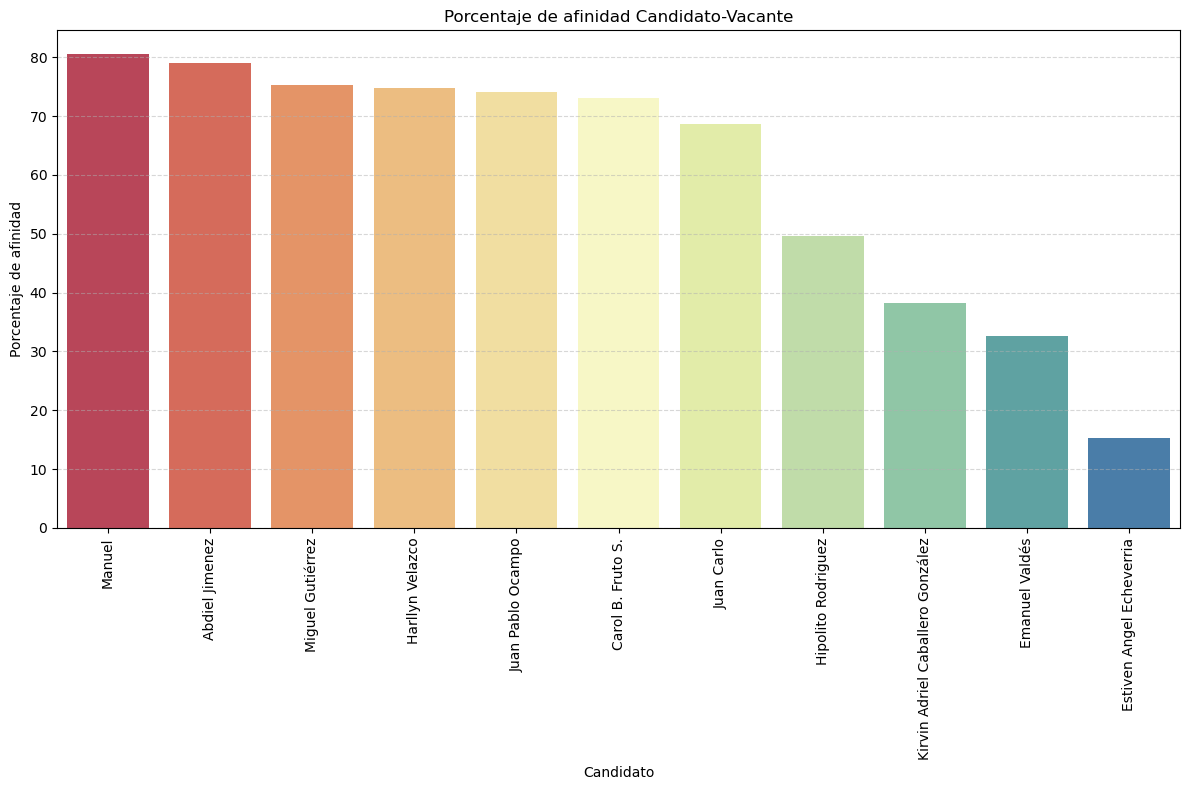

In [16]:
# Graficar los resultados de los porcentajes:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='Candidato', y='Porcentaje de afinidad', data=combinedScoresDF, hue='Candidato', palette='Spectral',ax=ax)
plt.title("Porcentaje de afinidad Candidato-Vacante")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

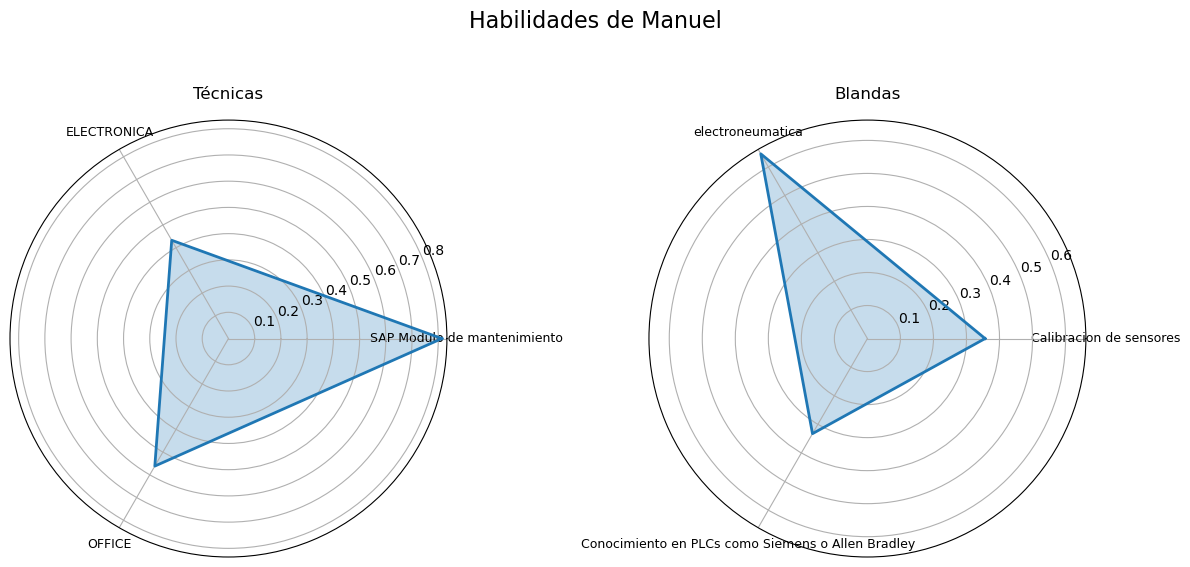

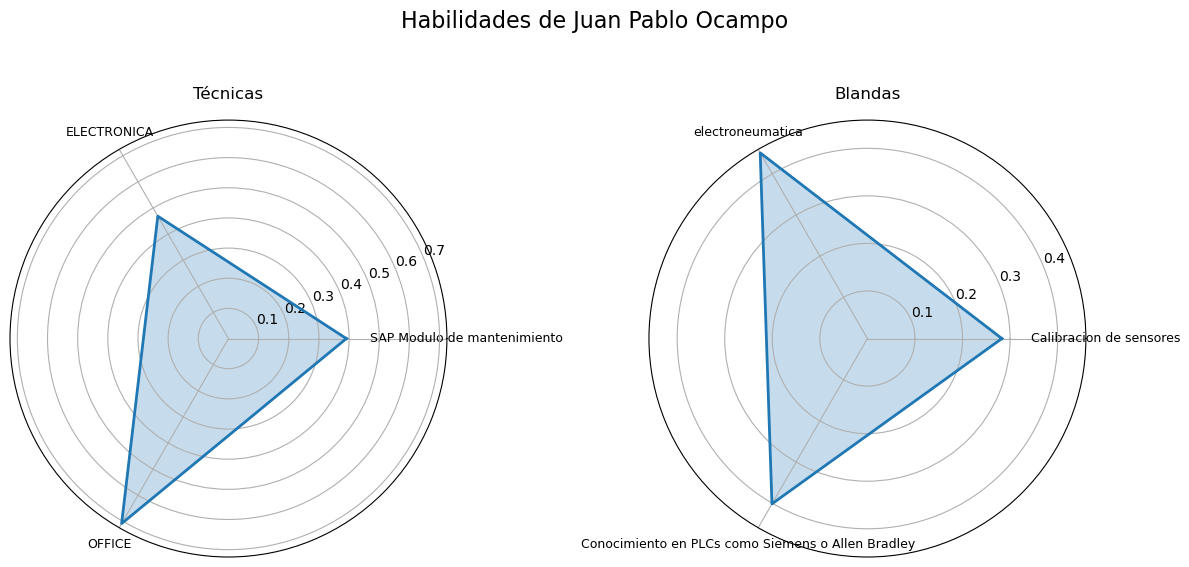

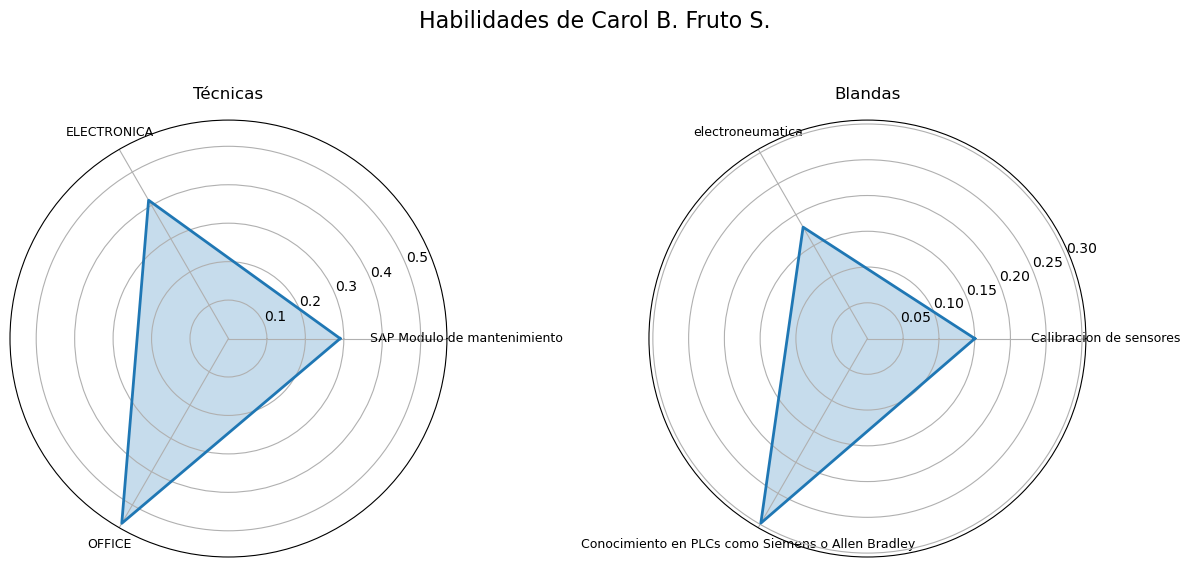

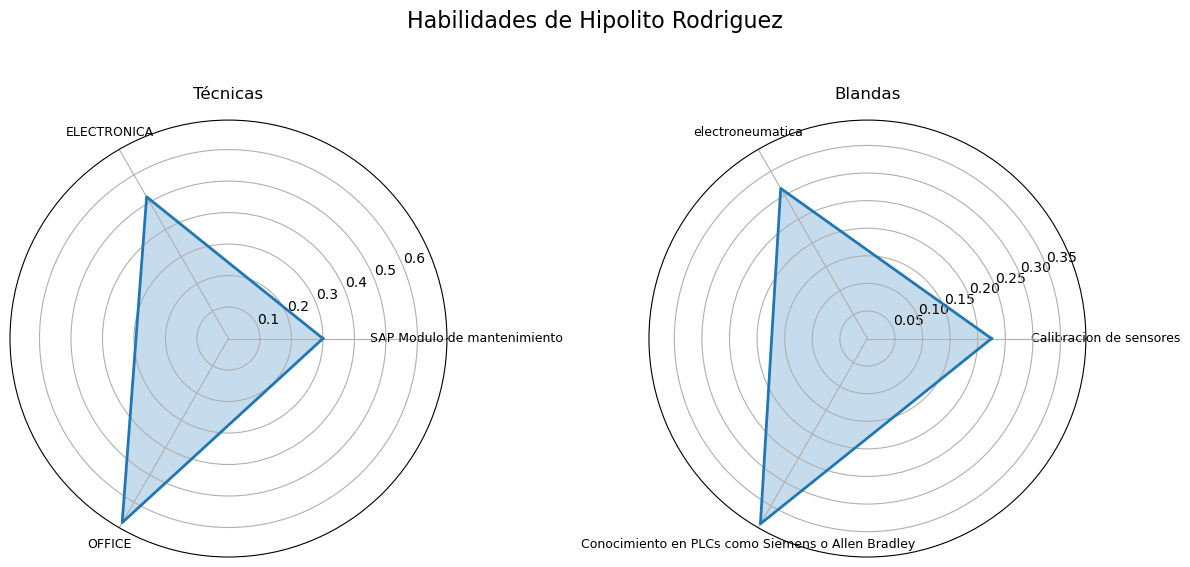

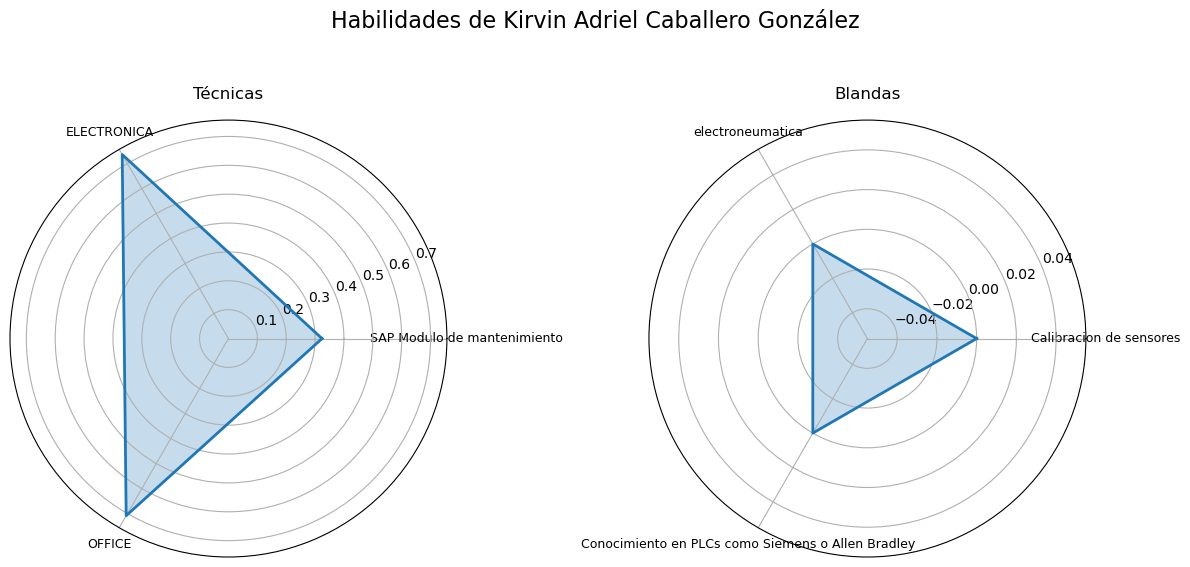

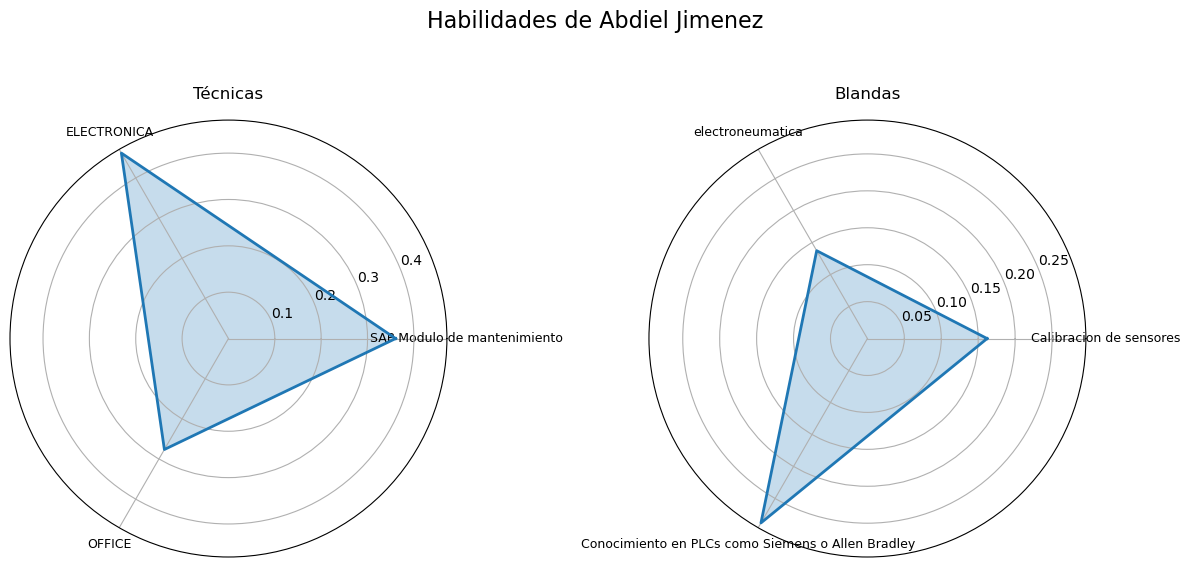

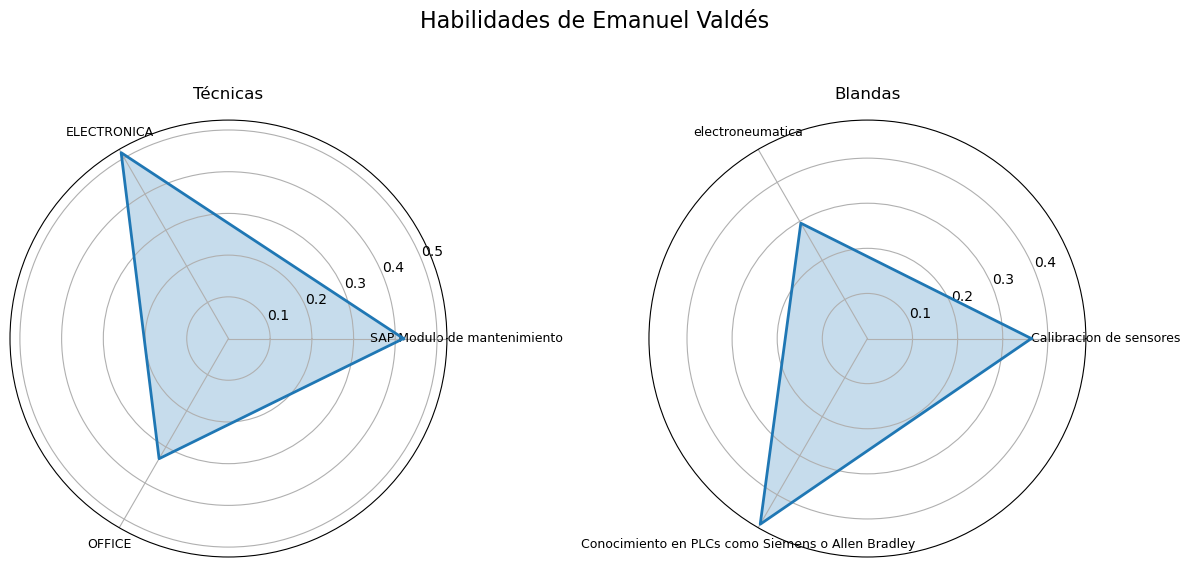

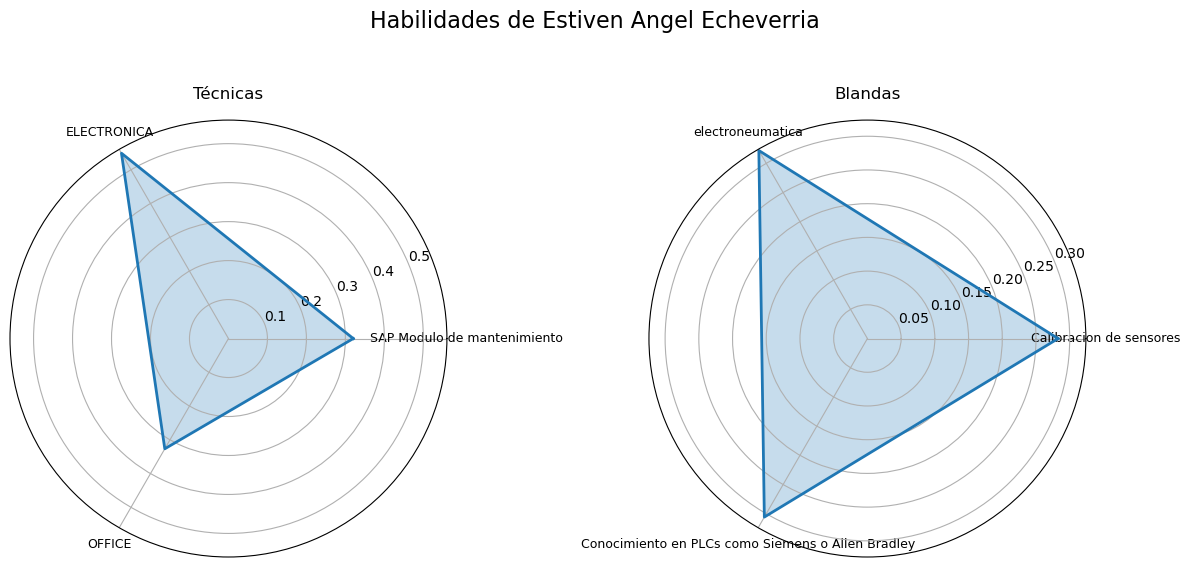

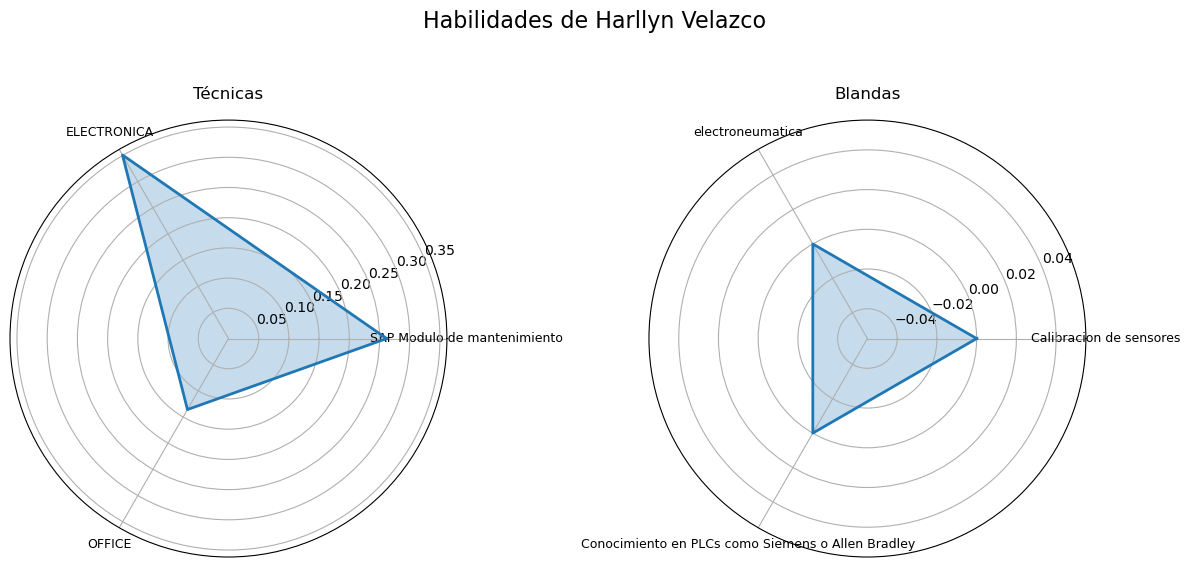

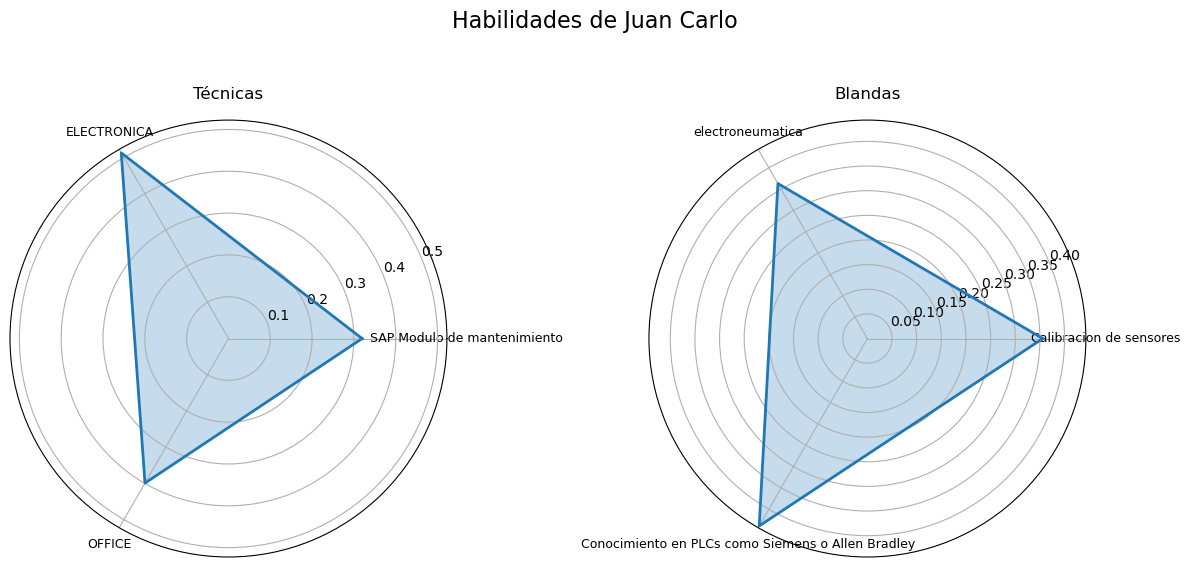

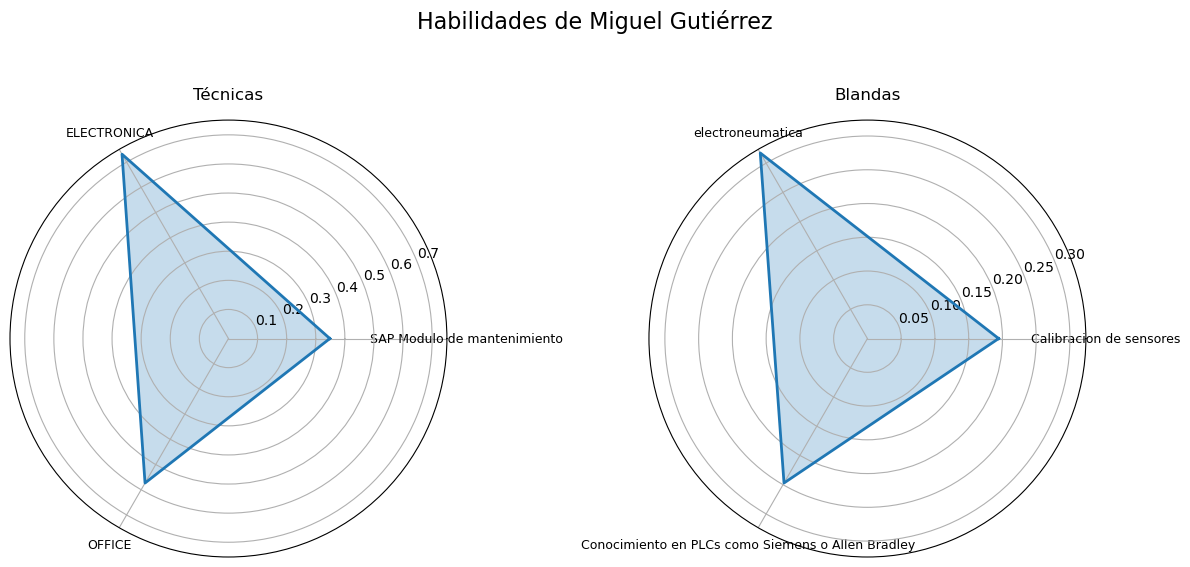

In [17]:
radarSkills(scoresPerSkill, jobInfo, mode="individual") # Graficar las habilidades de cada candidato

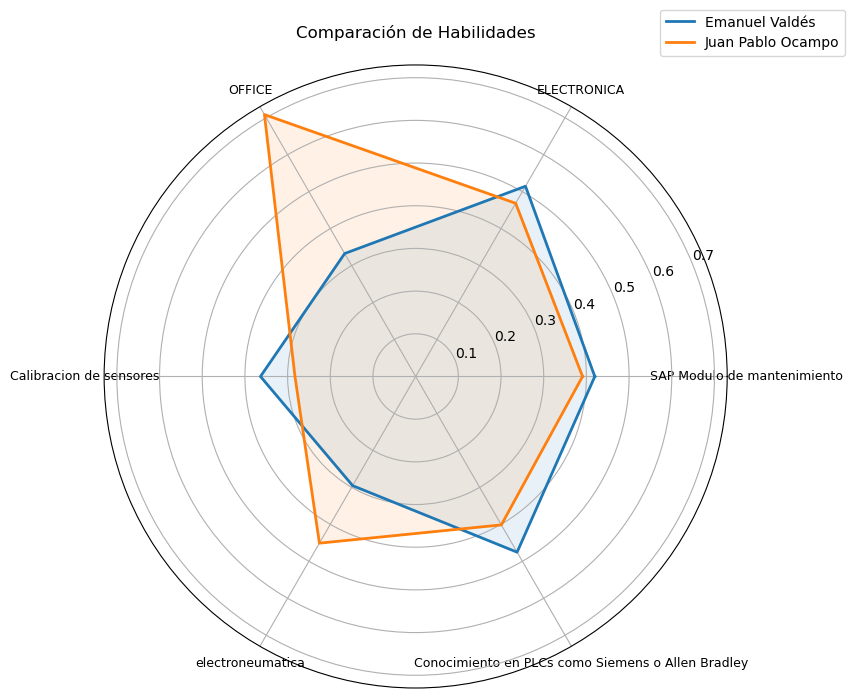

In [18]:
candidate1 = "Emanuel Valdés"
candidate2 = "Juan Pablo Ocampo"
radarSkills(scoresPerSkill, jobInfo, candidatos=[candidate1, candidate2], mode="compare")